# **Standardized Test Analysis**

## Problem Statement

Is the SAT an adequate measure of student intelligence, such that students--who exhibit interest in pursuing math-oriented majors--demonstrate higher math section SAT scores? Likewise, is this interest and perceived academic proficiency in English also reflected in students' English reading/writing section SAT scores?

How have these SAT statistics changed in the past eight years, particularly in response to the COVID-19 pandemic?


### Contents:
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Results](#Results)
- [Discussion](#Discussion)

### Code

In [46]:
# Imports:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns

### Helpful Functions

In [47]:
list_of_numbers = [1, 2, 4, 4, 5, 22, 5, 12]

def calculate_mean(numbers):
    return sum(numbers) / len(numbers)

calculate_mean(list_of_numbers)

6.875

In [48]:
list_of_numbers = [1, 2, 4, 4, 5, 22, 5, 12]

def calculate_sd(numbers):
    return sum([(number - calculate_mean(numbers)) ** 2 / len(numbers) for number in numbers]) ** 0.5
    

calculate_sd(list_of_numbers)

6.489173676208705

In [49]:
def convert_decimal(string_percent):
    return float(string_percent.strip("%"))/100.0

convert_decimal("22%")

0.22

## Data Import and Cleaning

**Do students’ English Reading & Writing and Math scores reflect their intended college major?**

In [50]:
# Create yearly SAT dataframes, add column for respective year
path = '../data/'
sat_2017 = pd.read_csv(f'{path}2017_SAT_Participation_Performance.csv')
sat_2018 = pd.read_csv(f'{path}2018_SAT_Participation_Performance.csv')
sat_2019 = pd.read_csv(f'{path}2019_SAT_Participation_Performance.csv')
sat_2020 = pd.read_csv(f'{path}2020_SAT_Participation_Performance.csv')
sat_2021 = pd.read_csv(f'{path}2021_SAT_Participation_Performance.csv')
sat_2022 = pd.read_csv(f'{path}2022_SAT_Participation_Performance.csv')
sat_2023 = pd.read_csv(f'{path}2023_SAT_Participation_Performance.csv')
sat_2024 = pd.read_csv(f'{path}2024_SAT_Participation_Performance.csv')


sat_2017['year'] = 2017
sat_2018['year'] = 2018
sat_2019['year'] = 2019
sat_2020['year'] = 2020
sat_2021['year'] = 2021
sat_2022['year'] = 2022
sat_2023['year'] = 2023
sat_2024['year'] = 2024

In [51]:
# Concatenate 2017-2024 dataframes
all_sat = pd.concat([sat_2017, sat_2018, sat_2019, sat_2020, sat_2021, sat_2022, sat_2023, sat_2024], axis = 0, ignore_index=True)

# Rename column names to lowercase, remove spaces
all_sat = all_sat.rename(columns = {'Intended College Major': 'intended_college_major',
                                    'Test Takers': 'test_takers',
                                    'Percent': 'percent',
                                    'Total' : 'total',
                                    'Mean Score ERW': 'erw_score',
                                    'Mean Score Math': 'math_score',
})

# Convert percent column to floats
all_sat['percent'] = all_sat['percent'].apply(convert_decimal)

# Lowercase rows
all_sat['intended_college_major'] = all_sat['intended_college_major'].str.lower()
all_sat

# Remove weird characters in intended_college_major rows
all_sat['intended_college_major'] = (
    all_sat['intended_college_major']
    .str.replace("‘", "")
    .str.replace(".", "")
    .str.replace("7", "")
)

# Remove trailing whitespace
all_sat['intended_college_major'] = all_sat['intended_college_major'].str.strip()

# Rename specific rows to correct typos
all_sat['intended_college_major'] = all_sat['intended_college_major'].replace({
    'muttiinterdisciplinary studies' : 'multi/interdisciplinary studies',
    'business, management, marketing, and related support servic': 'business, management, marketing, and related support services'
})

/var/folders/7s/q7dylcrs77vbhkh8gr32_jcr0000gn/T/ipykernel_36597/2548844744.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  all_sat['intended_college_major']


In [52]:
# Convert test_takers column to integers
def convert_integer(float_number):
    return int(float_number.replace(',',''))

all_sat['test_takers'] = all_sat['test_takers'].apply(convert_integer)

In [53]:
all_sat.dtypes

intended_college_major     object
test_takers                 int64
percent                   float64
total                       int64
erw_score                   int64
math_score                  int64
year                        int64
dtype: object

In [54]:
all_sat.isnull().sum()

intended_college_major    0
test_takers               0
percent                   0
total                     0
erw_score                 0
math_score                0
year                      0
dtype: int64

In [100]:
# Copy all_sat data
orientation_all_sat = all_sat.copy()

# Drop 'other' and 'undecided' majors
orientation_all_sat = orientation_all_sat[~orientation_all_sat["intended_college_major"].isin(["other", "undecided"])]

# Create new column that maps intended college major as either math- or english-oriented
math_oriented_majors = ["agriculture, agriculture operations, and related sciences",
    "architecture and related services",
    "biological and biomedical sciences",
    "business, management, marketing, and related support services",
    "computer and information sciences and support services",
    "construction trades, general",
    "engineering",
    "engineering technologies/technicians",
    "health professions and related clinical sciences",
    "mathematics and statistics",
    "mechanic and repair technologies/technicians",
    "military technologies",
    "natural resources and conservation",
    "physical sciences",
    "precision production",
    "transportation and materials moving"
]

english_oriented_majors = [
    "area, ethnic, cultural, and gender studies",
    "communication, journalism, and related programs",
    "education",
    "english language and literature/letters",
    "family and consumer sciences/human sciences",
    "foreign languages and literatures, general",
    "history, general",
    "legal studies, general",
    "liberal arts and sciences, general studies and humanities",
    "library science/librarianship",
    "multi/interdisciplinary studies",
    "parks, recreation and leisure studies",
    "personal and culinary services, general",
    "philosophy and religious studies",
    "psychology, general",
    "public administration and social service professions",
    "security and protective services",
    "social sciences",
    "theology and religious vocations",
    "visual and performing arts, general"
]

def categorize_major(major):
    if major in math_oriented_majors:
        return 'math'
    elif major in english_oriented_majors:
        return 'english'
    else:
        return 'undecided/other'
    
orientation_all_sat['orientation'] = orientation_all_sat['intended_college_major'].apply(categorize_major)

### Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|intended_college_major|object|all_sat|The category of intended college majors selected by students prior to taking the SAT in a given year.|
|test_takers|integer|all_sat|The number of test takers who selected an intended college major prior to taking the SAT in a given year.|
|percent|float|all_sat|The percentage of test takers who selected an intended college major out of the total number of test takers in a given year.|
|total|integer|all_sat|The average SAT score per college major, the sum of the English Reading/Writing score and the Math scores in a given year. The maximum cumulative score is 1600.|
|erw_score|integer|all_sat|The average English Reading/Writing score per college major in a given year. The maximum score in this category is 800.|
|math_score|integer|all_sat|The average Math score per college major in a given year. The maximum score in this category is 800.|
|year|integer|all_sat|The year in which the SAT was taken.|

## Exploratory Data Analysis

In [56]:
# What is the average SAT score across all years and intended majors?
all_sat[['total', 'erw_score', 'math_score']].mean()

total         1071.332143
erw_score      544.110714
math_score     527.607143
dtype: float64

**The average SAT score from 2017-2024 was 1068, with an average English Reading/Writing score of 544 and average math score of 527.**

In [57]:
# What is the average total SAT score, broken down into English reading/writing and math scores by year?
avg_per_year = all_sat.groupby('year').agg({
    'total':'mean',
    'erw_score':'mean',
    'math_score':'mean'
})

# Rename columns to indicate averages
avg_per_year = avg_per_year.rename(columns = {
    'total': 'avg_total',
    'erw_score': 'avg_erw',
    'math_score': 'avg_math'
})

avg_per_year.reset_index(inplace = True)
avg_per_year.head()

,year,avg_total,avg_erw,avg_math
0,2017,1062.236842,538.421053,523.815789
1,2018,1066.257143,539.000000,527.257143
2,2019,1058.388889,535.416667,523.111111
3,2020,1055.133333,535.066667,523.366667
4,2021,1081.805556,548.583333,533.194444


In [58]:
# What year had the lowest SAT score?
avg_per_year.sort_values('avg_total')

,year,avg_total,avg_erw,avg_math
3,2020,1055.133333,535.066667,523.366667
2,2019,1058.388889,535.416667,523.111111
0,2017,1062.236842,538.421053,523.815789
1,2018,1066.257143,539.000000,527.257143
6,2023,1073.500000,548.029412,525.588235
4,2021,1081.805556,548.583333,533.194444
5,2022,1084.694444,551.611111,533.055556
7,2024,1086.857143,555.971429,530.942857


**The year with the lowest average SAT score was 2019, with a total score of 1034. The average English Reading/Writing score in 2019 was 535 and the average math score was 523.**

In [59]:
# What is the average SAT score for each intended major? 
avg_per_major = all_sat.groupby('intended_college_major').agg({
    'total':'mean',
    'erw_score':'mean',
    'math_score':'mean'
})

# Rename columns to indicate averages
avg_per_major.rename(columns = {
    'total': 'avg_total',
    'erw_score': 'avg_erw',
    'math_score': 'avg_math'}, inplace = True)

avg_per_major.reset_index(inplace = True)
avg_per_major

,intended_college_major,avg_total,avg_erw,avg_math
0,"agriculture, agriculture operations, and relat...",979.375000,498.750000,481.500000
1,architecture and related services,1055.375000,526.375000,528.750000
2,"area, ethnic, cultural, and gender studies",1042.750000,539.000000,503.875000
3,biological and biomedical sciences,1144.833333,575.833333,568.666667
4,"business, management, marketing, and related s...",1072.000000,536.500000,535.500000
5,"communication, journalism, and related programs",1071.125000,552.750000,518.000000
6,computer and information sciences and support ...,1171.000000,579.000000,592.000000
7,"construction trades, general",936.571429,469.714286,466.714286
8,education,1028.500000,524.500000,504.000000
9,engineering,1158.250000,569.500000,589.125000


In [60]:
# What majors had the highest average total SAT score?
avg_per_major.sort_values('avg_total', ascending = False).head()

,intended_college_major,avg_total,avg_erw,avg_math
19,mathematics and statistics,1260.714286,608.571429,652.428571
28,physical sciences,1208.250000,601.500000,606.625000
22,multi/interdisciplinary studies,1179.125000,594.000000,585.750000
6,computer and information sciences and support ...,1171.000000,579.000000,592.000000
33,social sciences,1169.875000,598.625000,584.000000


**The intended college major with the highest average total SAT score across all years was Mathematics and Statistics, with a total score of 1260. The average English reading/writing score was 608 and the average math score was 652.** 

In [61]:
# What major had the lowest average total SAT score?
avg_per_major.sort_values('avg_total').head()

,intended_college_major,avg_total,avg_erw,avg_math
20,mechanic and repair technologies/technicians,936.000000,469.250000,466.000000
7,"construction trades, general",936.571429,469.714286,466.714286
26,"personal and culinary services, general",941.625000,481.875000,460.125000
29,precision production,956.333333,478.666667,477.333333
12,family and consumer sciences/human sciences,970.875000,495.250000,475.750000


**Agriculture, Agriculture Operations, and Related Sciences exhibited the lowest average SAT score across all years with a total score of 870. The average English reading/writing score was 498 and the average math score was 482.**

In [62]:
# What major had the lowest English reading/writing score?
avg_per_major.sort_values('avg_erw').head()

,intended_college_major,avg_total,avg_erw,avg_math
20,mechanic and repair technologies/technicians,936.000000,469.250000,466.000000
7,"construction trades, general",936.571429,469.714286,466.714286
29,precision production,956.333333,478.666667,477.333333
26,"personal and culinary services, general",941.625000,481.875000,460.125000
25,"parks, recreation and leisure studies",974.500000,491.250000,483.125000


**The Mechanic and Repair Technologies/Technicians intended college major exhibited the lowest average English reading/writing score across all seven years with a score of 469.**

In [63]:
# What major had the lowest math score?
avg_per_major.sort_values('avg_math').head()

,intended_college_major,avg_total,avg_erw,avg_math
26,"personal and culinary services, general",941.625000,481.875000,460.125000
20,mechanic and repair technologies/technicians,936.000000,469.250000,466.000000
7,"construction trades, general",936.571429,469.714286,466.714286
12,family and consumer sciences/human sciences,970.875000,495.250000,475.750000
29,precision production,956.333333,478.666667,477.333333


**The General Personal and Culinary Services intended major exhibited the lowest average math score across all seven years with a score of 460.**

In [88]:
# What major was the most consistent between sections (i.e. had the least difference between math and English scores)
avg_per_major['diff_btwn_scores'] = (avg_per_major['avg_erw'] - avg_per_major['avg_math'])

# Drop  'other' and 'undecided' rows
avg_per_major = avg_per_major[~avg_per_major["intended_college_major"].isin(["other", "undecided"])]

# Create new column that maps intended_college_major as either math- or english-oriented
avg_per_major['orientation'] = avg_per_major['intended_college_major'].apply(categorize_major)
avg_per_major.sort_values('diff_btwn_scores', ascending = False)

/var/folders/7s/q7dylcrs77vbhkh8gr32_jcr0000gn/T/ipykernel_36597/1847079478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_per_major['diff_btwn_scores'] = (avg_per_major['avg_erw'] - avg_per_major['avg_math'])


,intended_college_major,avg_total,avg_erw,avg_math,diff_btwn_scores,orientation
18,library science/librarianship,1135.375000,597.875000,537.500000,60.375000,english
11,english language and literature/letters,1136.625000,596.625000,539.875000,56.750000,english
15,"history, general",1114.250000,577.250000,536.750000,40.500000,english
2,"area, ethnic, cultural, and gender studies",1042.750000,539.000000,503.875000,35.125000,english
5,"communication, journalism, and related programs",1071.125000,552.750000,518.000000,34.750000,english
13,"foreign languages and literatures, general",1116.250000,575.000000,541.125000,33.875000,english
37,"visual and performing arts, general",1054.600000,544.000000,510.800000,33.200000,english
34,theology and religious vocations,1100.625000,566.250000,534.250000,32.000000,english
17,"liberal arts and sciences, general studies and...",1151.428571,591.571429,559.857143,31.714286,english
30,"psychology, general",1070.375000,550.875000,519.625000,31.250000,english


**The major with the smallest difference between English reading/writing and math scores was Business, Management, Marketing, and Related Support Services with a differential of only 1 point.**

In [65]:
# What major was the least consistent between sections (i.e. had the greatest difference between math and English scores)
avg_per_major.sort_values('diff_btwn_scores', ascending = False).head()

,intended_college_major,avg_total,avg_erw,avg_math,diff_btwn_scores,orientation
18,library science/librarianship,1135.375,597.875,537.500,60.375,english
11,english language and literature/letters,1136.625,596.625,539.875,56.750,english
15,"history, general",1114.250,577.250,536.750,40.500,english
2,"area, ethnic, cultural, and gender studies",1042.750,539.000,503.875,35.125,english
5,"communication, journalism, and related programs",1071.125,552.750,518.000,34.750,english


**The major with the greatest difference between English reading/writing and math scores was Library Science/Librarianship with a differential of 60 points.** 

**To-Do:** *Edit this cell with your findings on trends in the data (step 3 above).*

In [66]:
# What is the average SAT score for math-oriented majors?

# Isolate math-oriented majors using mask from all_sat df
math_majors = all_sat[all_sat['intended_college_major'].isin(math_oriented_majors)]

# Group by major to determine average SAT stats irrespective of year
math_by_major = math_majors.groupby('intended_college_major').mean()

# Drop test_takers, percent, and year column
math_by_major.drop(columns = ['test_takers','percent', 'year'], inplace = True)

**The average total SAT score for math-oriented majors was 1065, with an average English reading/writing score of 544 and an average math score of 527.**

In [67]:
# What is the average SAT score for english-oriented majors?

# Isolate english-oriented majors by using a mask from all_sat df
english_majors = all_sat[all_sat['intended_college_major'].isin(english_oriented_majors)]

# Group by major to determine SAT scores across all years
english_by_major = english_majors.groupby('intended_college_major').mean()

# Drop test_takers, percent, and year columns
english_by_major = english_by_major.drop(columns = ['test_takers', 'percent', 'year'])

**The average total SAT score for English-oriented majors was 1075, with an average English reading/writing score of 553 and an average math score of 523.**

In [68]:
# By year, what is the average SAT score for math-oriented majors?
math_by_year = math_majors.groupby('year').mean()

# Drop test-takers and percent column
math_by_year = math_by_year.drop(columns = ['test_takers', 'percent'])
math_by_year.reset_index(inplace = True)
math_by_year

,year,total,erw_score,math_score
0,2017,1064.250000,531.062500,533.125000
1,2018,1071.937500,534.187500,537.750000
2,2019,1058.187500,527.562500,531.000000
3,2020,1049.333333,524.666667,524.333333
4,2021,1091.071429,543.857143,547.142857
5,2022,1094.857143,547.071429,547.714286
6,2023,1091.833333,546.916667,545.000000
7,2024,1094.769231,550.769231,544.000000


In [69]:
# What year exhibited the highest average total score for math-oriented majors?
math_by_year.sort_values('total', ascending = False)

,year,total,erw_score,math_score
5,2022,1094.857143,547.071429,547.714286
7,2024,1094.769231,550.769231,544.000000
6,2023,1091.833333,546.916667,545.000000
4,2021,1091.071429,543.857143,547.142857
1,2018,1071.937500,534.187500,537.750000
0,2017,1064.250000,531.062500,533.125000
2,2019,1058.187500,527.562500,531.000000
3,2020,1049.333333,524.666667,524.333333


**The highest average total SAT score for math-oriented majors was in 2022, with a score of 1095. Additionally, 2022 also exhibited the highest average math scores for math-oriented majors with a score of 548.**

In [70]:
# What year exhibited the lowest average English reading/writing score for math-oriented majors?
math_by_year.sort_values('erw_score')

,year,total,erw_score,math_score
3,2020,1049.333333,524.666667,524.333333
2,2019,1058.187500,527.562500,531.000000
0,2017,1064.250000,531.062500,533.125000
1,2018,1071.937500,534.187500,537.750000
4,2021,1091.071429,543.857143,547.142857
6,2023,1091.833333,546.916667,545.000000
5,2022,1094.857143,547.071429,547.714286
7,2024,1094.769231,550.769231,544.000000


**The lowest average English reading/writing score for math-oriented majors occurred in 2020 with a score of 524.**

In [71]:
# By year, what is the average SAT score for english-oriented majors?
english_by_year = english_majors.groupby('year').mean()

# Drop test-takers and percent column
english_by_year = english_by_year.drop(columns = ['test_takers', 'percent'])
english_by_year.reset_index(inplace = True)
english_by_year

,year,total,erw_score,math_score
0,2017,1065.050000,546.700000,518.400000
1,2018,1065.588235,546.000000,519.588235
2,2019,1063.578947,544.526316,518.947368
3,2020,1062.823529,544.411765,524.470588
4,2021,1084.850000,556.850000,528.000000
5,2022,1086.400000,559.400000,527.000000
6,2023,1071.900000,553.650000,518.400000
7,2024,1091.050000,564.250000,526.850000


In [72]:
# What year exhibited the highest average total score for English-oriented majors?
english_by_year.sort_values('total', ascending = False)

,year,total,erw_score,math_score
7,2024,1091.050000,564.250000,526.850000
5,2022,1086.400000,559.400000,527.000000
4,2021,1084.850000,556.850000,528.000000
6,2023,1071.900000,553.650000,518.400000
1,2018,1065.588235,546.000000,519.588235
0,2017,1065.050000,546.700000,518.400000
2,2019,1063.578947,544.526316,518.947368
3,2020,1062.823529,544.411765,524.470588


**The highest average total score for English-oriented majors occurred in 2024 with a score of 1091. Additionally, 2024 also exhibited the greatest English reading/writing score, with a score of 564.**

In [73]:
# What year exhibited the lowest average math score for English-oriented majors?
english_by_year.sort_values('math_score')

,year,total,erw_score,math_score
0,2017,1065.050000,546.700000,518.400000
6,2023,1071.900000,553.650000,518.400000
2,2019,1063.578947,544.526316,518.947368
1,2018,1065.588235,546.000000,519.588235
3,2020,1062.823529,544.411765,524.470588
7,2024,1091.050000,564.250000,526.850000
5,2022,1086.400000,559.400000,527.000000
4,2021,1084.850000,556.850000,528.000000


**The lowest average math score for English-oriented majors occurred in 2017 with a score of 518.**

In [98]:
# What is the percentage of intended majors over time?
major_percent_dist = all_sat.pivot_table(
    index = 'intended_college_major',
    columns = 'year',
    values = 'percent'
)

# Rename columns for clarity
major_percent_dist = major_percent_dist.rename(
    columns={year: f'percent_{year}' for year in range(2017, 2025)}
)

# Add a new column to include range of percents
major_percent_dist['percent_range'] = (
    major_percent_dist.loc[:, 'percent_2017':'percent_2024'].max(axis=1) -
    major_percent_dist.loc[:, 'percent_2017':'percent_2024'].min(axis=1)
)

# What majors have exhibited the greatest changes over the past 7 years?
major_percent_dist.sort_values('percent_range', ascending = False).head()

# Reset index
major_percent_dist.reset_index(inplace = True)

# Add new column for major orientation
major_percent_dist['orientation'] = major_percent_dist['intended_college_major'].apply(categorize_major)
major_percent_dist.sort_values('percent_range', ascending = False).head()

year,intended_college_major,percent_2017,percent_2018,percent_2019,percent_2020,percent_2021,percent_2022,percent_2023,percent_2024,percent_range,orientation
9,engineering,0.11,0.11,0.01,0.10,0.10,0.10,0.10,0.10,0.10,math
14,health professions and related clinical sciences,0.19,0.19,0.18,0.17,0.11,0.14,0.13,0.12,0.08,math
36,undecided,0.08,0.08,NaN,0.09,0.11,0.12,0.12,0.10,0.04,undecided/other
4,"business, management, marketing, and related s...",0.11,0.12,0.12,0.12,0.12,0.13,0.14,0.13,0.03,math
6,computer and information sciences and support ...,0.04,0.04,0.04,NaN,0.05,0.06,0.07,0.06,0.03,math


**The top two majors that have exhibited the greatest changes in intended college major preference include engineering and health professions and related clinical sciences, with a ten and eight percent change across seven years, respectively.** 

In [75]:
# From major_percent_dist df, create new df that sums percentage for math and english per year
orientation_percent = major_percent_dist.groupby('orientation').sum(numeric_only=True)
orientation_percent = orientation_percent.rename(columns = {
    'percent_2017':'2017',
    'percent_2018':'2018',
    'percent_2019':'2019',
    'percent_2020':'2020',
    'percent_2021':'2021',
    'percent_2022':'2022',
    'percent_2023':'2023',
    'percent_2024':'2024',
})

orientation_percent.drop(columns = 'percent_range', inplace = True)
orientation_percent = orientation_percent.T

In [76]:
affected_majors = ['health professions and related clinical sciences',
                   'education',
                   'business, management, marketing, and related support services',
                   'visual and performing arts, general',
                   'personal and culinary services, general',
                   'computer and information sciences and support services']

affected_major_dist = major_percent_dist[major_percent_dist['intended_college_major'].isin(affected_majors)]
affected_major_dist = affected_major_dist.ffill(axis = 1)
affected_major_dist.drop(columns = ['percent_range', 'orientation'], inplace = True)
affected_major_dist = affected_major_dist.rename(columns = {
    'percent_2017':'2017',
    'percent_2018':'2018',
    'percent_2019':'2019',
    'percent_2020':'2020',
    'percent_2021':'2021',
    'percent_2022':'2022',
    'percent_2023':'2023',
    'percent_2024':'2024',
})
affected_major_dist = affected_major_dist.set_index('intended_college_major').T

## Results

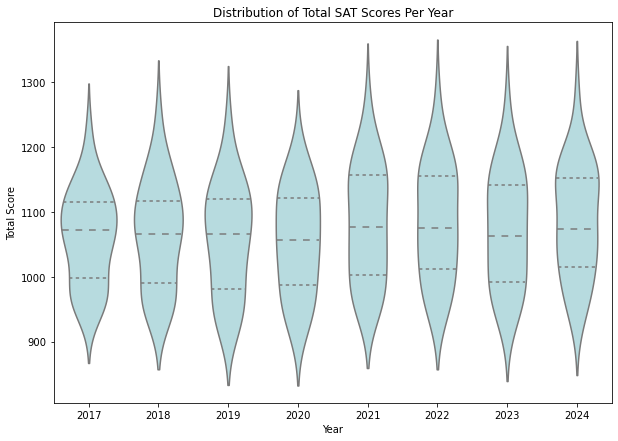

In [101]:
# Distribution of Total SAT Scores Per Year
plt.figure(figsize = (10,7))
sns.violinplot(data = all_sat, x = 'year', y = 'total', color = 'powderblue', inner = 'quartile')

plt.xlabel('Year')
plt.ylabel('Total Score')
plt.title('Distribution of Total SAT Scores Per Year');

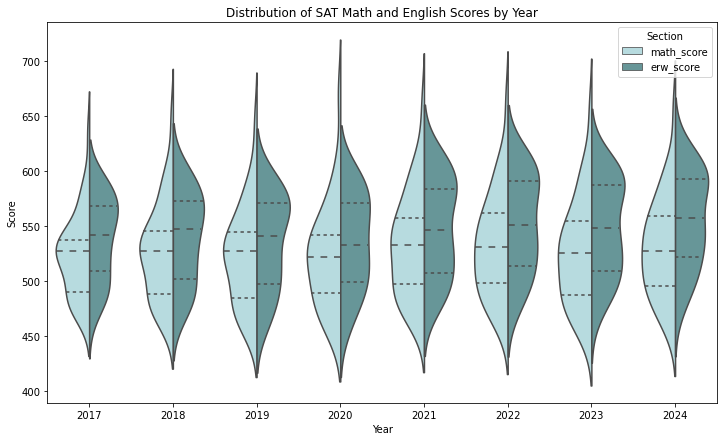

In [90]:
# Distribution of SAT Math and English Scores by Year
plt.figure(figsize = (12,7))
sns.violinplot(
    data = all_sat.melt(id_vars = ['year'], 
                        value_vars = ['math_score','erw_score'],
                        var_name = 'section',
                        value_name = 'score'),
    x = 'year',
    y = 'score',
    split = True,
    hue = 'section',
    inner = 'quartile',
    palette={'math_score': 'powderblue', 'erw_score': 'cadetblue'}
    )

plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Distribution of SAT Math and English Scores by Year')
plt.legend(title = 'Section');

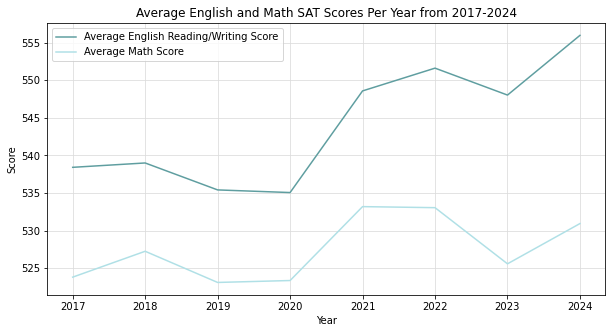

In [79]:
# Average English and Math SAT Scores from 2017-2024
plt.figure(figsize=(10, 5))
x = avg_per_year['year']
y1 = avg_per_year['avg_erw']
y2 = avg_per_year['avg_math']

plt.plot(x, y1, label = 'Average English Reading/Writing Score', color = 'cadetblue')
plt.plot(x, y2, label = 'Average Math Score', color = 'powderblue')
plt.title('Average English and Math SAT Scores Per Year from 2017-2024')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend()
plt.grid(color = 'gainsboro');

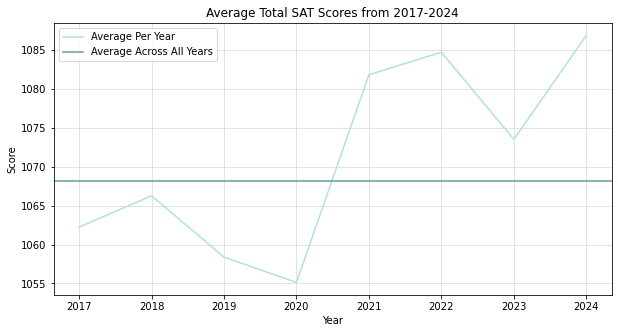

In [80]:
# Average Total SAT Scores Per Year from 2017 to 2024
plt.figure(figsize=(10, 5))
x = avg_per_year['year']
y = avg_per_year['avg_total']

plt.plot(x, y, label = 'Average Per Year', color = 'powderblue')
plt.title('Average Total SAT Scores from 2017-2024')
plt.xlabel('Year')
plt.ylabel('Score')
plt.axhline(y = 1068.214286, color = 'cadetblue', label = 'Average Across All Years')
plt.legend()
plt.grid(color = 'gainsboro');

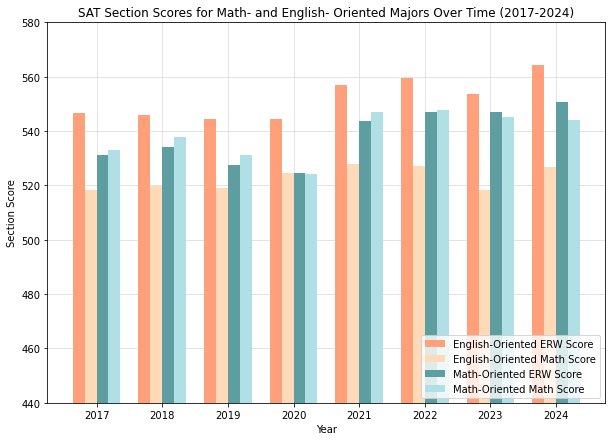

In [84]:
# Distribution of SAT Scores for Math- and English- Oriented Majors Over Time
plt.figure(figsize = (10,7))
x = np.arange(len(english_by_year['year']))
y1 = english_by_year['erw_score']
y2 = english_by_year['math_score']
y3 = math_by_year['erw_score']
y4 = math_by_year['math_score']

width = 0.2
spacing = 0.3
x_positions = x * (4 * width + spacing)

plt.bar(x_positions - 1.5 * width, y1, width = width, label = 'English-Oriented ERW Score', color = 'lightsalmon', zorder = 3)
plt.bar(x_positions - 0.5 * width, y2, width = width, label = 'English-Oriented Math Score', color = 'peachpuff', zorder = 3)
plt.bar(x_positions + 0.5 * width, y3, width = width, label = 'Math-Oriented ERW Score', color = 'cadetblue', zorder = 3)
plt.bar(x_positions + 1.5 * width, y4, width = width, label = 'Math-Oriented Math Score', color = 'powderblue', zorder = 3)

plt.legend(loc = 'lower right')
plt.xticks(x_positions, english_by_year['year'])
plt.title('SAT Section Scores for Math- and English- Oriented Majors Over Time (2017-2024)')
plt.xlabel('Year')
plt.ylabel('Section Score')
plt.ylim(440, 580)
plt.grid(color = 'gainsboro', zorder = 2);

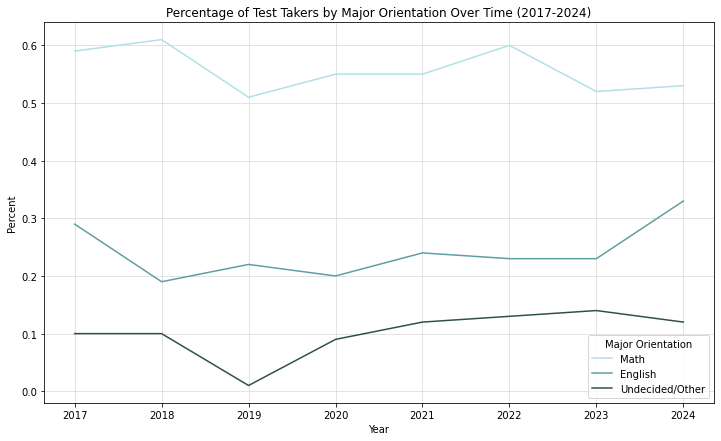

In [107]:
# How have the percentages of math- and english-oriented majors changed over time?
plt.figure(figsize = (12, 7))
x = orientation_percent.index
y1 = orientation_percent['math']
y2 = orientation_percent['english']
y3 = orientation_percent['undecided/other']

plt.plot(x, y1, label = 'Math', color = 'powderblue', zorder = 3)
plt.plot(x, y2, label = 'English', color = 'cadetblue', zorder = 3)
plt.plot(x, y3, label = 'Undecided/Other', color = 'darkslategrey', zorder = 3)

plt.legend(title = 'Major Orientation', loc = 'lower right')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.title('Percentage of Test Takers by Major Orientation Over Time (2017-2024)')
plt.grid(color = 'gainsboro', zorder = 0);

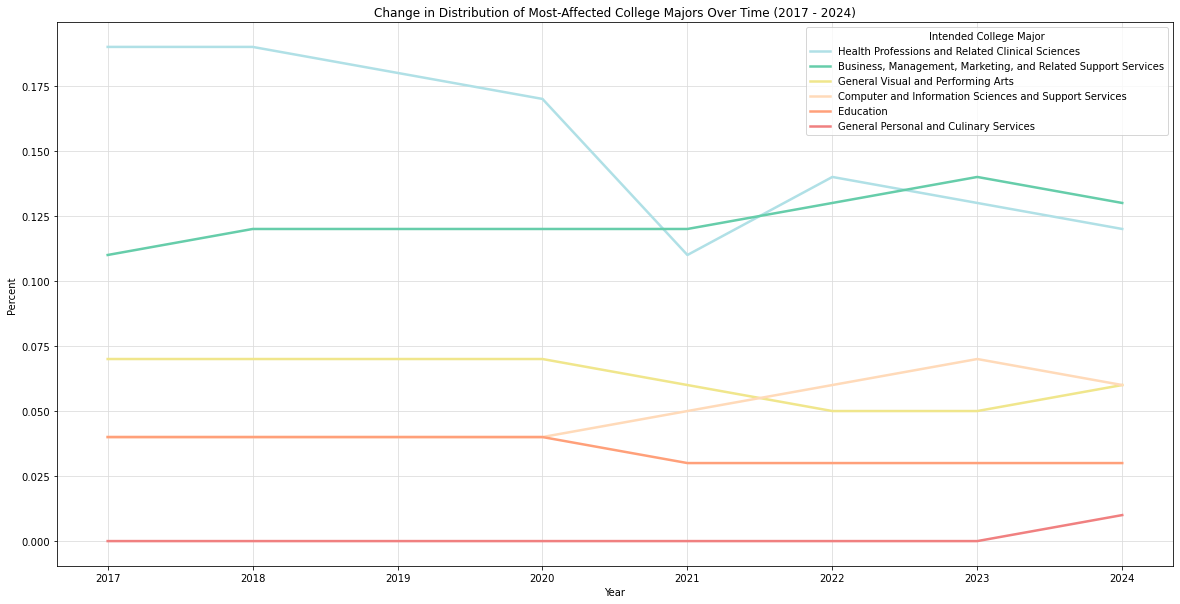

In [97]:
# Change in Most-Affected College Majors Over Time
plt.figure(figsize = (20,10))
x = affected_major_dist.index
y1 = affected_major_dist['business, management, marketing, and related support services']
y2 = affected_major_dist['computer and information sciences and support services']
y3 = affected_major_dist['education']
y4 = affected_major_dist['personal and culinary services, general']
y5 = affected_major_dist['visual and performing arts, general']
y6 = affected_major_dist['health professions and related clinical sciences']

plt.plot(x, 
         y6, 
         label = 'Health Professions and Related Clinical Sciences', 
         color = 'powderblue',
         zorder = 3, 
         lw = 2.5)
plt.plot(x, 
         y1, 
         label = 'Business, Management, Marketing, and Related Support Services', 
         color = 'mediumaquamarine', 
         zorder = 3, 
         lw = 2.5)
plt.plot(x, 
         y5, 
         label = 'General Visual and Performing Arts', 
         color = 'khaki', 
         zorder = 3, 
         lw = 2.5)
plt.plot(x, 
         y2, 
         label = 'Computer and Information Sciences and Support Services', 
         color = 'peachpuff', 
         zorder = 3, 
         lw = 2.5)
plt.plot(x, 
         y3, 
         label = 'Education', 
         color = 'lightsalmon', 
         zorder = 3, 
         lw = 2.5)
plt.plot(x, 
         y4, 
         label = 'General Personal and Culinary Services', 
         color = 'lightcoral', 
         zorder = 3, 
         lw = 2.5)

plt.xlabel('Year')
plt.ylabel('Percent')
plt.title('Change in Distribution of Most-Affected College Majors Over Time (2017 - 2024)')
plt.legend(title = 'Intended College Major', loc = 'upper right')
plt.grid(color = 'gainsboro', zorder = 0);

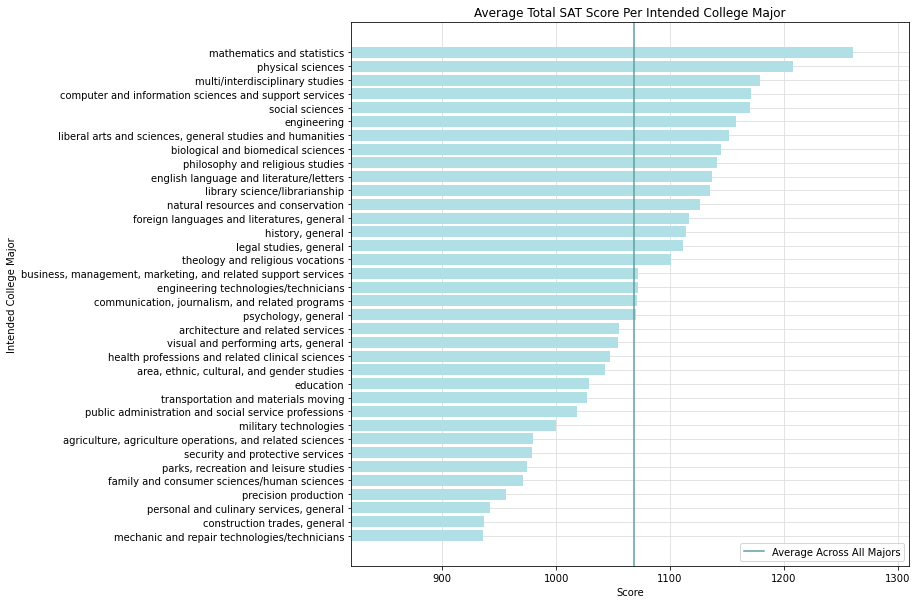

In [94]:
# Average SAT Score Per Intended College Major
plt.figure(figsize = (10,10))
x = avg_per_major.sort_values('avg_total')['intended_college_major']
y = avg_per_major.sort_values('avg_total')['avg_total']

plt.barh(x, y, color = 'powderblue', zorder = 2)
plt.title('Average Total SAT Score Per Intended College Major')
plt.ylabel('Intended College Major')
plt.xlabel('Score', zorder = 6)
plt.axvline(x = 1068.214286, color = 'cadetblue', label = 'Average Across All Majors')
plt.legend(loc = 'lower right')
plt.xlim(820, 1310)
plt.grid(color = 'gainsboro', zorder = 0);

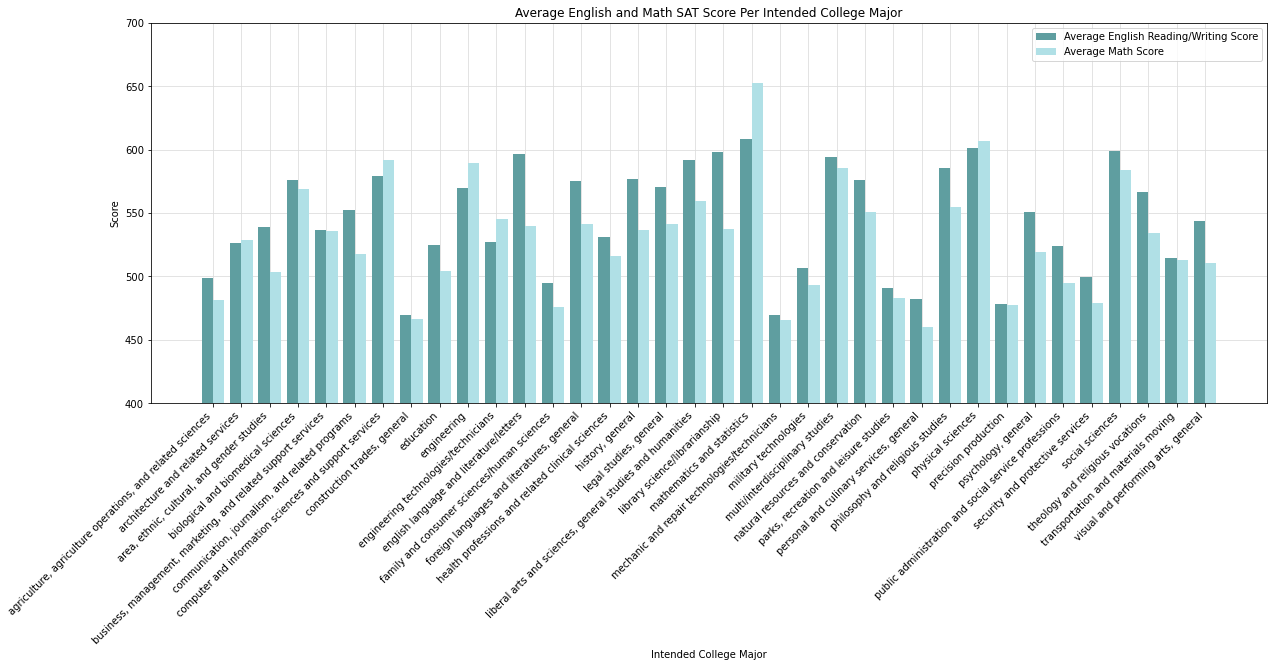

In [82]:
# Average English and Math SAT Score Per Intended College Major
plt.figure(figsize = (20,7))
x = avg_per_major['intended_college_major']
y1 = avg_per_major['avg_erw']
y2 = avg_per_major['avg_math']

x = np.arange(len(avg_per_major))
width = 0.4

plt.bar(x - width/2, y1, width, label='Average English Reading/Writing Score', color = 'cadetblue', zorder = 3)
plt.bar(x + width/2, y2, width, label='Average Math Score', color = 'powderblue', zorder = 3)
plt.title('Average English and Math SAT Score Per Intended College Major')
plt.xticks(x, avg_per_major['intended_college_major'], rotation= 45, ha='right')
plt.xlabel('Intended College Major')
plt.ylabel('Score')
plt.ylim(400, 700)
plt.legend()
plt.grid(color = 'gainsboro', zorder = 0);

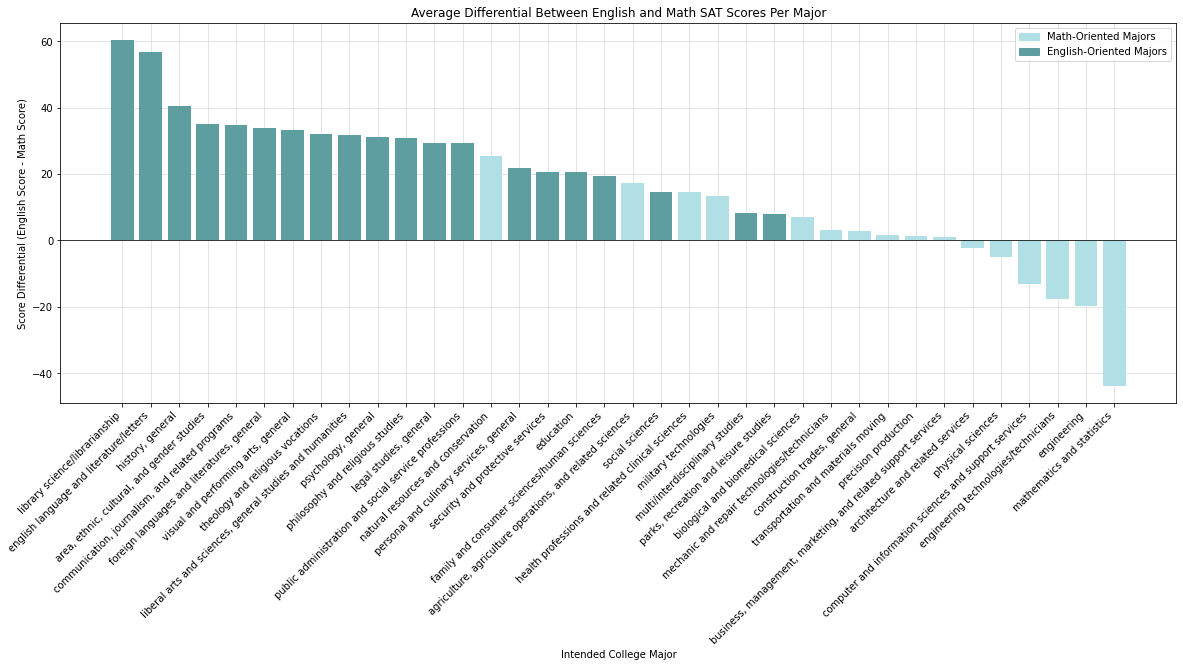

In [83]:
# Consistency Between Math and English SAT Sections Per Major
plt.figure(figsize=(20, 7))
x = avg_per_major.sort_values('diff_btwn_scores', ascending=False)['intended_college_major']
y = avg_per_major.sort_values('diff_btwn_scores', ascending=False)['diff_btwn_scores']
colors = ['powderblue' if orientation == 'math' else 'cadetblue' for orientation in avg_per_major.sort_values('diff_btwn_scores', ascending=False)['orientation']]

plt.bar(x, y, color=colors, zorder = 3)
plt.xlabel('Intended College Major')
plt.ylabel('Score Differential (English Score - Math Score)')
plt.axhline(0, color='black', lw=0.75, zorder = 4)
plt.title('Average Differential Between English and Math SAT Scores Per Major')
plt.xticks(zorder = 0, rotation=45, ha='right')
plt.grid(color = 'gainsboro')

math_patch = mpatches.Patch(color='powderblue', label='Math-Oriented Majors')
english_patch = mpatches.Patch(color='cadetblue', label='English-Oriented Majors')

plt.legend(handles=[math_patch, english_patch]);

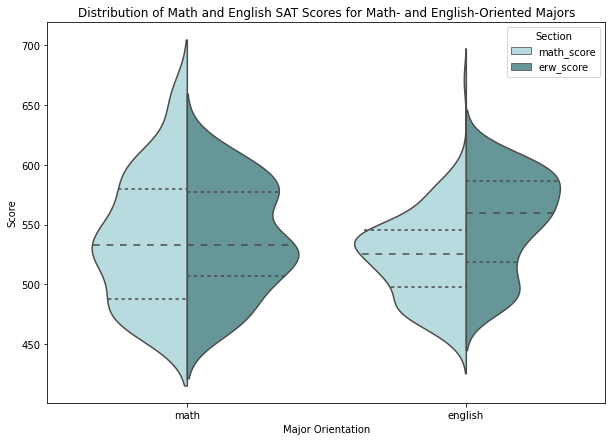

In [108]:
# Distribution of Math and English-Oriented SAT Scores
plt.figure(figsize = (10,7))
sns.violinplot(data = orientation_all_sat.melt(
    id_vars = ['orientation'],
    value_vars = ['math_score', 'erw_score'],
    var_name = 'section',
    value_name = 'score'),
    
    x = 'orientation',
    y = 'score',
    split = True,
    hue = 'section',
    inner = 'quartile',
    palette = {'math_score': 'powderblue', 'erw_score': 'cadetblue'},
    )

plt.title('Distribution of Math and English SAT Scores for Math- and English-Oriented Majors')
plt.xlabel('Major Orientation')
plt.ylabel('Score')
plt.legend(title = 'Section');

### Discussion

#### Key Points



**-  The COVID-19 pandemic demonstrated significant impacts on several SAT metrics, both immediate and long-term.**
>    -  Test takers in 2020 exhibited the lowest scores across the seven-year range, an abnormality in the overall trending increase in scores. 
>>    -  This is likely due to the College Board pausing testing in March, May, and June of 2020.
>>    -  School closures likely also affected SAT School Day, in which schools, districts, and states offer the SAT to juniors and seniors in school, on a weekday, usually at no cost to students.
>    -  2023 also exhibited a local minimum score, breaking the growing trend in SAT scores post-pandemic.
>>    -  This may be a delayed response to the pandemic’s reshaping class environments. Juniors who took the SAT in 2023 began their high school careers in the midst of online classes. The lack of in-person teaching may have created gaps in English and math skills.  

**-  Pandemic-era changes to college class structure and job outlook also likely played a role in students' intended college major decisions.**
>    -  An average of 50 percent of test takers intended to pursue a math-oriented major across the seven year period. This percentage was the lowest in 2019, and steadily climbed back up in 2022.
>>    -  In particular, the Health Professions and Related Clinical Sciences major exhibited a strong decrease in percentage in 2021, likely due to the COVID-19 pandemic, mass hospitalizations, politicization, and overworked healthcare workers. 
>>    -  The Business, Management, Marketing, and Related Support Services major, as well as the Computer and Information Sciences and Support Services major exhibited growth starting in 2020, yet slightly declined in 2024. The uptick in percentage starting in 2020 may be due to the jobs’ ease in a work-from-home format. The COVID-19 era also saw immense job growth in these fields, and could incentivize high school test takers to pursue such a career. The 2024 decrease may be a result of back-to-office initiatives and a slower job market. Furthermore, as other industries that were greatly affected by COVID-19 return to normal operating conditions, such as fine arts and restaurant businesses, students may be more incentivized to pursue alternate career paths.

>    -  An average of 25 percent of test takers intended to pursue an English-oriented major.
>>    -  In particular, the Visual and Performing Arts major and the Education major both strongly declined starting in 2020, likely caused by pandemic regulations. Limitations on social gatherings and social distancing greatly affected the entertainment industry, and possibly de-incentivized students from pursuing this career avenue. Online class formats were unprecedented for teachers, and many schools were understaffed as a result. These greater demands from teachers may have discouraged many test takers from pursuing Education as a major. 
>>    -  The General Personal and Culinary Services major had remained consistently steady until 2024, in which its percentage increased. 

**-  Other changes made by the College Board may have also impacted students' SAT scores.**
   
>   -  2024 exhibited the highest total SAT scores
>>    - This is possibly due to a switch from paper-based to digital tests, implemented by the College Board starting in 2024. 
>>    -  The structure of the digital tests also changed. Tests were shortened from 3 hours to 2 hours long and became adaptive. Thus, each section--math and reading/writing--consisted of two modules. The student’s performance and demonstrated level on the first module dictated the content on the second module.

**-  There is an overall bias favoring English scores, regardless of major orientation, though this bias is slightly ameliorated in math-oriented majors. Furthermore, math-oriented majors exhibited more overall consistency–or a smaller difference–between math and English section scores.** <br>
>    -   Business, Management, Marketing, and Related Support Services exhibited a difference of only one point between math and English section scores.

**-  The SAT may not be an adequate measure of student intelligence as it relates to math-oriented fields, but may be a positive indicator of proficiency in English-oriented fields.** <br> 
>    -  STEM majors such as Mathematics and Statistics, Physical Sciences, Computer and Information Sciences, Engineering, and Biological and Biomedical Sciences averaged the highest total SAT scores. Conversely, more trade-oriented majors such as Mechanic and Repair Technologies, Construction, Personal and Culinary Services, and Security averaged the lowest total SAT scores.
>    -  17 percent of all intended majors, and less than half (40 percent) of the intdended math-oriented majors exhibited higher math section scores than English scores: Architecture and Related Services, Computer and Information Sciences, Engineering, Engineering Technologies/Technicians, Mathematics and Statistics, and Physical Sciences.

**-  Revision to the SAT math section or prioritization of math concepts in classes is necessary to better prepare the 50 percent of students who exhibit interest in math-oriented fields.** 